<head>
    <img src="https://www.smu.edu/~/media/Site/DevelopmentExternalAffairs/MarketingCommunications/Logos/smu/SMULogoRrgb" alt="SMU_logo" style="width:auto;height:100px;float:left; padding:5px"/>
     <img src="http://content.sportslogos.net/logos/7/1007/full/4710.gif" alt="NFL_logo" style="width:auto;height:100px;float:right; padding:5px"/>
<h1 style="text-align:center; font:40px Verdana; font-weight:bold">DS 7331 - Data Mining (Lab 2)</h1>
</head>

Date submitted: July 7, 2019<br>
Authors: Venkat Kasarla, Javier Saldaña Jr., & Adam Sheerer
<br><br>
## Data Preparation I
>Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [1]:
#import packages
import pandas as pd
import numpy as np
from sklearn import metrics as mt
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

#import data set
ORIG_NFL = pd.read_csv("NFL.csv")

For this project, we will be predicting two seperate variables. For the first prediction models, we will attempt to determine if the outcome of the play is going to be a run attempt. The second set of prediction models will attempt to determine if a field goal is successful. In an effort to stay within the rubric outline, we will work on both prediction sets side-by-side.
<br><br>
### Data Prep - Run Prediction
In order to attempt to predict whether the `play_type` is a <i>run</i>, we will extract only the relevant variables that pertain to elements prior to the start of the play.
<br><br>
<div style="height:200px;overflow:auto;">
<table>
  <tr>
      <th>Variables</th><th></th>    <th>Data Type</th><th></th>    <th>Description</th>
  </tr><tr>
    <td>two_point_attempt</td><th></th>      <td>Int64</td><th></th>      <td>Identifies if the play is a two-point attempt</td>
    </tr><tr>
    <td>posteam_score</td><th></th>      <td>Int64</td><th></th>      <td>Current score of the team with possession</td>
  </tr><tr>
    <td>defteam_score</td><th></th>      <td>Int64</td><th></th>      <td>Current score of defending team</td>
    </tr><tr>
    <td>score_differential</td><th></th>      <td>Int64</td><th></th>      <td>Differential of current scores from both teams</td>
  </tr><tr>
    <td>posteam_timeouts_remaining</td><th></th>      <td>Int64</td><th></th>      <td>Number of timeouts remaining for team with possession</td>
    </tr><tr>
    <td>defteam_timeouts_remaining</td><th></th>      <td>Int64</td><th></th>      <td>Number of timeouts remaining for defending team</td>
  </tr><tr>
    <td>yardline_100</td><th></th>      <td>Int64</td><th></th>      <td>Yardline identifier from scale 0 - 100</td>
    </tr><tr>
    <td>home_team_pos</td><th></th>      <td>Int64</td><th></th>      <td>Identifies if team with possession is home team</td>
  </tr><tr>
    <td>shotgun</td><th></th>      <td>Int64</td><th></th>      <td>Identifies if the offensive formation is a shotgun formation</td>
    </tr><tr>
    <td>no_huddle</td> <th></th>     <td>Int64</td> <th></th>     <td>Identifies if a huddle was held prior to the formation</td>
  </tr><tr>
    <td>play_type_run</td> <th></th>     <td>Int64</td><th></th>      <td>Identifies if the play is a run attempt</td>
    </tr><tr>
    <td>ydstogo</td> <th></th>     <td>Int64</td><th></th>      <td>Indicates how many yards are needed to convert a first down</td>
  </tr><tr>
    <td>down</td> <th></th>     <td>Int64</td> <th></th>     <td>Identifies which down the play is being executed on</td>
    </tr><tr>
    <td>drive</td><th></th>      <td>Int64</td><th></th>      <td>Identifies which drive the play is being executed on</td>
  </tr><tr>
    <td>qtr</td><th></th>      <td>Int64</td> <th></th>     <td>Indicates which quarter the game time is currently on</td>
  </tr>
</table>
</div>

<br><br>The table above shows the desired variables and their data type we would need in order to be able to run our models for the prediction. The `play_type` variable would get transposed to only account for running plays as events. This new variable gets named `play_type_run` in the table. The `posteam_type` would also get transposed to only count home teams as events, which is why it is then renamed `home_team_pos` in the table. Below is the output confirming the data has been prepared and is properly being read as its given type in the data frame.

In [2]:
#Extract the following variables to make a new dataframe to use for the model
nfl_run = ORIG_NFL[['two_point_attempt','posteam_score', 'defteam_score', 'score_differential', 'posteam_timeouts_remaining', 
                'defteam_timeouts_remaining', 'shotgun', 'no_huddle', 'play_type', 'ydstogo', 'down', 'drive', 'qtr', 
                'game_seconds_remaining', 'yardline_100', 'posteam_type']].copy()

#View the variables to determine if Pandas read them into the dataframe accordingly
nfl_run = nfl_run[(nfl_run.play_type == 'run') | (nfl_run.play_type == 'pass') | (nfl_run.play_type == 'field_goal') | 
          (nfl_run.play_type == 'qb_spike') | (nfl_run.play_type == 'qb_kneel') | (nfl_run.play_type == 'punt')]
nfl_run = nfl_run.fillna(0)

#Several variables were read in as floats when they should be integers.
#List of the variables misclassified as floats
cols = ['two_point_attempt', 'posteam_score', 'defteam_score', 'score_differential', 'posteam_timeouts_remaining',
        'defteam_timeouts_remaining', 'down', 'game_seconds_remaining', 'yardline_100']

#Convert variable list to integers
nfl_run[cols] = nfl_run[cols].applymap(np.int64)

#transpose play_types into different columns and add back into dataframe
tmp_nfl_run = pd.get_dummies(nfl_run.play_type,prefix='play_type')
nfl_run = pd.concat((nfl_run,tmp_nfl_run),axis=1)

#create new variable in which posteam_type now refers to home_possession
nfl_run['home_team_pos'] = nfl_run.posteam_type == 'home' 
nfl_run.home_team_pos = nfl_run.home_team_pos.astype(np.int64) #convert to int64

#drop all excess columns
nfl_run = nfl_run.drop(['posteam_type','play_type','play_type_field_goal', 'play_type_pass', 'play_type_qb_kneel', 'play_type_qb_spike', 'play_type_punt'], axis = 1)

nfl_run.play_type_run = nfl_run.play_type_run.astype(np.int64) #convert to int64

nfl_run.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357580 entries, 1 to 449369
Data columns (total 16 columns):
two_point_attempt             357580 non-null int64
posteam_score                 357580 non-null int64
defteam_score                 357580 non-null int64
score_differential            357580 non-null int64
posteam_timeouts_remaining    357580 non-null int64
defteam_timeouts_remaining    357580 non-null int64
shotgun                       357580 non-null int64
no_huddle                     357580 non-null int64
ydstogo                       357580 non-null int64
down                          357580 non-null int64
drive                         357580 non-null int64
qtr                           357580 non-null int64
game_seconds_remaining        357580 non-null int64
yardline_100                  357580 non-null int64
play_type_run                 357580 non-null int64
home_team_pos                 357580 non-null int64
dtypes: int64(16)
memory usage: 46.4 MB


### Data Prep - Successful FG Prediction
Just like the previous instance, we will extract only the relevant variables in order to attempt to predict whether the `field_goal_result` was successful. The table below describes the final data types and variables we will use for these predictions.
<br><br>
<div style="height:200px;overflow:auto;">
<table>
  <tr>
      <th>Variables</th><th></th>    <th>Data Type</th><th></th>    <th>Description</th>
  </tr><tr>
    <td>yardline_100</td><th></th>      <td>Int64</td><th></th>      <td>Yardline identifier from scale 0 - 100</td>
    </tr><tr>
    <td>drive</td><th></th>      <td>Int64</td><th></th>      <td>Identifies which drive the play is being executed on</td>
  </tr><tr>
    <td>qtr</td><th></th>      <td>Int64</td> <th></th>     <td>Indicates which quarter the game time is currently on</td>
    </tr><tr>
    <td>down</td> <th></th>     <td>Int64</td> <th></th>     <td>Identifies which down the play is being executed on</td>
  </tr><tr>
    <td>ydstogo</td> <th></th>     <td>Int64</td><th></th>      <td>Indicates how many yards are needed to convert a first down</td>
    </tr><tr>
    <td>kick_distance</td><th></th>      <td>Int64</td><th></th>      <td>Distance in yards for kick to make it to the goal post</td>
  </tr><tr>
    <td>posteam_timeouts_remaining</td><th></th>      <td>Int64</td><th></th>      <td>Number of timesout remaining for team with possession</td>
    </tr><tr>
    <td>defteam_timeouts_remaining</td><th></th>      <td>Int64</td><th></th>      <td>Number of timeouts remaining for defending team</td>
  </tr><tr>
    <td>posteam_score</td><th></th>      <td>Int64</td><th></th>      <td>Current score of team with possession</td>
    </tr><tr>
    <td>defteam_score</td> <th></th>     <td>Int64</td> <th></th>     <td>Current score of defending team</td>
  </tr><tr>
    <td>score_differential</td> <th></th>     <td>Int64</td><th></th>      <td>Differential in current score of both teams</td>
    </tr><tr>
    <td>fieldgoal_made</td> <th></th>     <td>Int64</td><th></th>      <td>Identifies whether a field attempt was successful</td>
  </tr><tr>
    <td>hometeam_pos</td> <th></th>     <td>Int64</td> <th></th>     <td>Identifies whether the team with possession is the home team</td>
    </tr>
</table>
</div>

<br><br>In order to ensure the data types are all consistent, we ensured the variables are all integers. In this case, we dropped all NAs from `field_goal_result`, which would essentially drop all plays in which there was no field goal attempt. By transposing the `field_goal_result` variable into `fieldgoal_made`, we essentially combined blocked and missed and declared a successful field as the event. We also went ahead and decided to also add the `home_team_pos` variable and have it tranaposed similar to the way it was done in the run data set. This was done in order to see whether the home field advantage has any effect on the result of the field goal.

In [3]:
#Extract the following variables to make a new dataframe to use for the model
nfl_fg = ORIG_NFL[['posteam_type', 'yardline_100', 'game_seconds_remaining', 'drive', 'qtr', 'down', 'ydstogo',
'field_goal_result', 'kick_distance', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
'posteam_score', 'defteam_score', 'score_differential']].copy()

#View the variables to determine if Pandas read them into the dataframe accordingly
nfl_fg = nfl_fg[(nfl_fg.field_goal_result == 'made') | (nfl_fg.field_goal_result == 'missed')
               | (nfl_fg.field_goal_result == 'blocked')]
nfl_fg = nfl_fg.fillna(0)

#Several variables were read in as floats when they should be integers.
#List of the variables misclassified as floats
cols = ['yardline_100', 'game_seconds_remaining', 'down', 'kick_distance', 'posteam_timeouts_remaining',
        'defteam_timeouts_remaining', 'posteam_score', 'defteam_score', 'score_differential']

#Convert variable list to integers
nfl_fg[cols] = nfl_fg[cols].applymap(np.int64)

#transpose play_types into different columns and add back into dataframe
tmp_nfl_fg = pd.get_dummies(nfl_fg.field_goal_result,prefix='fieldgoal')
nfl_fg = pd.concat((nfl_fg,tmp_nfl_fg),axis=1)

#create new variable in which posteam_type now refers to home_possession
nfl_fg['home_team_pos'] = nfl_fg.posteam_type == 'home' 
nfl_fg.home_team_pos = nfl_fg.home_team_pos.astype(np.int64) #convert to int64

#drop all excess columns
nfl_fg = nfl_fg.drop(['posteam_type','field_goal_result', 'fieldgoal_blocked', 'fieldgoal_missed'], axis = 1)

nfl_fg.fieldgoal_made = nfl_fg.fieldgoal_made.astype(np.int64) #convert to int64

#view to ensure all variables are int
nfl_fg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9813 entries, 20 to 449253
Data columns (total 14 columns):
yardline_100                  9813 non-null int64
game_seconds_remaining        9813 non-null int64
drive                         9813 non-null int64
qtr                           9813 non-null int64
down                          9813 non-null int64
ydstogo                       9813 non-null int64
kick_distance                 9813 non-null int64
posteam_timeouts_remaining    9813 non-null int64
defteam_timeouts_remaining    9813 non-null int64
posteam_score                 9813 non-null int64
defteam_score                 9813 non-null int64
score_differential            9813 non-null int64
fieldgoal_made                9813 non-null int64
home_team_pos                 9813 non-null int64
dtypes: int64(14)
memory usage: 1.1 MB


## Data Preparation II
>Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

#### The `nfl_run` data set
Once the relevant variables and instances are gathered, we are left with 357,580 records. All the variables are the same data type (int64). There are are two newly created variables in this final data set. The `play_type_run` variable identifies if the play executed is a run play. The `home_team_pos` play identifies if the team executing the play is the home team.

In [4]:
nfl_run.describe()

,two_point_attempt,posteam_score,defteam_score,score_differential,posteam_timeouts_remaining,defteam_timeouts_remaining,shotgun,no_huddle,ydstogo,down,drive,qtr,game_seconds_remaining,yardline_100,play_type_run,home_team_pos
count,357580.000000,357580.000000,357580.000000,357580.000000,357580.000000,357580.000000,357580.000000,357580.000000,357580.000000,357580.000000,357580.000000,357580.000000,357580.000000,357580.000000,357580.000000,357580.000000
mean,0.001896,10.218620,11.448227,-1.229607,2.543308,2.561539,0.467837,0.078587,8.593350,1.992186,12.105932,2.563888,1729.277216,52.397931,0.371083,0.502358
std,0.043503,9.534498,10.029034,10.836720,0.762199,0.734493,0.498965,0.269093,4.121568,1.010700,7.104158,1.132444,1049.640247,24.702822,0.483095,0.499995
min,0.000000,0.000000,0.000000,-59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000,-7.000000,2.000000,2.000000,0.000000,0.000000,6.000000,1.000000,6.000000,2.000000,815.000000,34.000000,0.000000,0.000000
50%,0.000000,7.000000,10.000000,0.000000,3.000000,3.000000,0.000000,0.000000,10.000000,2.000000,12.000000,3.000000,1795.000000,56.000000,0.000000,1.000000
75%,0.000000,16.000000,17.000000,4.000000,3.000000,3.000000,1.000000,0.000000,10.000000,3.000000,18.000000,4.000000,2621.000000,73.000000,1.000000,1.000000
max,1.000000,61.000000,61.000000,59.000000,3.000000,3.000000,1.000000,1.000000,50.000000,4.000000,38.000000,5.000000,3600.000000,99.000000,1.000000,1.000000


Looking at the plot below, we can see there are more instances in which the run play is not executed. However, considering this includes a every single other type of play possible, we can easily see that the run is in fact pretty pupular. This is certainly supported by the philosophy of many NFL teams. The run is essential to the foundation of any strategy of the game, regardless of which team is playing. Even for pass heavy teams like the New England Patriots, the versatile running backs is what forces linebackers to stay in the box and respect the run, which is what helps augment the mismatch between the linebacker and the tight ends.

<function matplotlib.pyplot.show(*args, **kw)>

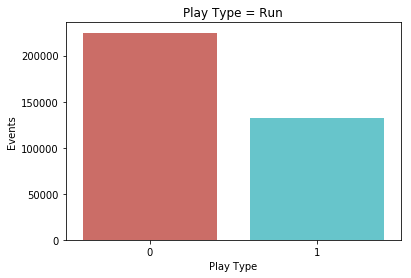

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='play_type_run', data=nfl_run, palette='hls')
plt.title('Play Type = Run')  
plt.xlabel('Play Type')
plt.ylabel('Events')
plt.show

#### The `nfl_fg` data set
The final composition of the data set has 9,813 records. All the variables are relevant and the same data type (int64). The only newly created variables are `fieldgoal_made` and `home_team_pos`. The `field_goal_made` variable declares if a field goal attempt was successful. In this new variable, a successful field goal = 1 and an unsuccessful field goal = 0. The `home_team_pos` variable identifies if the home team is the team performing the field goal attempt.

In [7]:
nfl_fg.describe()

,yardline_100,game_seconds_remaining,drive,qtr,down,ydstogo,kick_distance,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,fieldgoal_made,home_team_pos
count,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000
mean,19.517884,1659.512789,11.851014,2.569551,3.834505,7.243656,37.508713,2.252013,2.388362,10.611536,10.044940,0.566595,0.838276,0.512585
std,10.254398,982.898365,6.815355,1.108273,0.604309,4.693244,10.302134,0.983754,0.903686,9.432972,8.600899,9.296799,0.368216,0.499867
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-41.000000,0.000000,0.000000
25%,11.000000,817.000000,6.000000,2.000000,4.000000,4.000000,29.000000,2.000000,2.000000,3.000000,3.000000,-4.000000,1.000000,0.000000
50%,20.000000,1804.000000,12.000000,2.000000,4.000000,6.000000,38.000000,3.000000,3.000000,9.000000,9.000000,0.000000,1.000000,1.000000
75%,28.000000,2441.000000,17.000000,4.000000,4.000000,10.000000,46.000000,3.000000,3.000000,17.000000,16.000000,6.000000,1.000000,1.000000
max,61.000000,3547.000000,38.000000,5.000000,4.000000,33.000000,71.000000,3.000000,3.000000,53.000000,48.000000,46.000000,1.000000,1.000000


A deeper dive into the `fieldgoal_made` variable shows us that most of the data is successful field goals. This distribution is understandable in the NFL since NFL teams must <i>know</i> the limitations of their kicker. The kicker's sole job is to perform kick offs and field goals. This allows NFL coaches to know the range of their kicker before they even set into the field. However, the kickers are usually kicking the ball in ideal conditions. Once the game has started, the coaches are not able to control plenty of other external variables which add to the pressure of the kicker. Coaches account for these factors and make decisions in order to minimize the risk of an unsuccessful field.

<function matplotlib.pyplot.show(*args, **kw)>

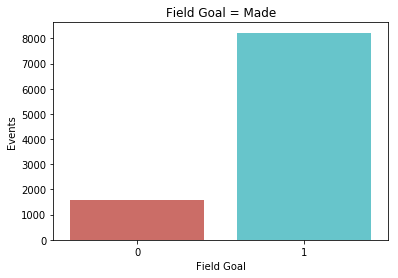

In [8]:
sns.countplot(x='fieldgoal_made', data=nfl_fg, palette='hls')
plt.title('Field Goal = Made')  
plt.xlabel('Field Goal')
plt.ylabel('Events')
plt.show

## Modeling & Evaluation I
>Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your  modeling? Give a detailed explanation backing up any assertions.

For the `nfl_run` models and the `nfl_fg` models, we will use precision as our performance metric. In both instances, the cost of a flase-negative is much higher than the cost of a false-positive. While accurancy is a strong metric within its own right, its limitations don't allow it to penalize the errors as much as it should. Failure to recognize that significance could be the difference between a scoring play or a turnover, both of which have implication to change the course of the game's final outcome. For this very reason, precision will help us find the right model while also ensuring we account for the true cost of the errors.
<br><br>
In addition, the heavy skew in the `fieldgoal_made` variable would mean that the model could simply categorize everything as a successful field goal and the accuracy will show a high accuracy rate. The best way to avoid this is to apply the precision metric all around.

## Modeling & Evaluation II
>Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

### `nfl_run` Data Split
Considering our data sets are vastly different sizes, we will be utilizing two different methods for dividing our data into the training and test splits. With over 350,000 records, the `nfl_run` data set is an ideal candidate for the `StratifiedShuffleSplit` method. <i>"This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class"</i> [1](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html). By opting for this route, we are able to get a blend of cross-validation while preserving computing power.

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit 

#create checkpoint
nfl_run_copy = nfl_run.copy()

#creating the X and y
if 'play_type_run' in nfl_run:\
y_run = nfl_run['play_type_run'].values # get the labels we want
del nfl_run['play_type_run'] # get rid of the class label
X_run = nfl_run.values # use other columns to predict

#create the split
cv_object = StratifiedShuffleSplit( n_splits=10,test_size=0.2)
print(cv_object)

StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.2,
            train_size=None)


### `nfl_fg` Data Split
However, the `nfl_fg` data set is much smaller than the other set. With just under 10,000 records, the `StratifiedKfold` method is ideal for the `nfl_fg` data set. <i>"This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class"</i> [2](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html). By using the `StratifiedKfold` method, we will be able to perform cross-validation while preserving computing power.

In [10]:
from sklearn.model_selection import StratifiedKFold

#Create checkpoint
nfl_fg_copy = nfl_fg.copy()

# #creating the X and y
if 'fieldgoal_made' in nfl_fg:\
y_fg = nfl_fg['fieldgoal_made'].values # get the labels we want
del nfl_fg['fieldgoal_made'] # get rid of the class label
X_fg = nfl_fg.values # use other columns to predict

# #create the split
skf_fg = StratifiedKFold(n_splits=10)

print(skf_fg)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


## Modeling & Evaluation III
>Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

### Predicting the Run

#### Logistic Regression

In [19]:
%%time
from sklearn.metrics import classification_report

# logistic model
lr_clf = LogisticRegression(penalty='l2', C=1, class_weight=None)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# loop for logistic regression model
print(lr_clf)
for train_indices_run, test_indices_run in cv_object.split(X_run,y_run): 

    X_run_train = X_run[train_indices_run]
    y_run_train = y_run[train_indices_run]
    
    X_run_test = X_run[test_indices_run]
    y_run_test = y_run[test_indices_run]

    lr_clf.fit(X_run_train,y_run_train)  # train model
    y_hat_run = lr_clf.predict(X_run_test) # test model

    acc = mt.accuracy_score(y_run_test,y_hat_run) # accuracy of model for given instance
    prec = mt.precision_score(y_run_test,y_hat_run) # precision score of model
    print('\n#',iter_num+1,"Cross-Validation\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%')
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_run_test, y_hat_run))# print performance metrics of model

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

# 1 Cross-Validation
 Accuracy: 72.16 %
 Precision: 64.08 %

# 2 Cross-Validation
 Accuracy: 72.17 %
 Precision: 64.05 %

# 3 Cross-Validation
 Accuracy: 72.44 %
 Precision: 64.48 %

# 4 Cross-Validation
 Accuracy: 72.65 %
 Precision: 64.76 %

# 5 Cross-Validation
 Accuracy: 72.36 %
 Precision: 64.2 %

# 6 Cross-Validation
 Accuracy: 72.29 %
 Precision: 64.09 %

# 7 Cross-Validation
 Accuracy: 72.24 %
 Precision: 64.22 %

# 8 Cross-Validation
 Accuracy: 72.44 %
 Precision: 64.49 %

# 9 Cross-Validation
 Accuracy: 72.3 %
 Precision: 64.41 %

# 10 Cross-Validation
 Accuracy: 72.19 %
 Precision: 64.06 %

Avg. Accuracy: 72.32 %
Avg. Precision: 64.28 %
              precision    recall  f1-score   support

           0       0.76   

In [20]:
%%time
# logistic model
lr_clf = LogisticRegression(penalty='l2', C=5, class_weight=None)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# loop for logistic regression model
print(lr_clf)
for train_indices_run, test_indices_run in cv_object.split(X_run,y_run): 

    X_run_train = X_run[train_indices_run]
    y_run_train = y_run[train_indices_run]
    
    X_run_test = X_run[test_indices_run]
    y_run_test = y_run[test_indices_run]

    lr_clf.fit(X_run_train,y_run_train)  # train model
    y_hat_run = lr_clf.predict(X_run_test) # test model

    acc = mt.accuracy_score(y_run_test,y_hat_run) # accuracy of model for given instance
    prec = mt.precision_score(y_run_test,y_hat_run) # precision score of model
    print('\n#',iter_num+1,"Cross-Validation\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%')
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_run_test, y_hat_run))# print performance metrics of model

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

# 1 Cross-Validation
 Accuracy: 72.42 %
 Precision: 64.59 %

# 2 Cross-Validation
 Accuracy: 72.51 %
 Precision: 64.61 %

# 3 Cross-Validation
 Accuracy: 72.39 %
 Precision: 64.4 %

# 4 Cross-Validation
 Accuracy: 72.68 %
 Precision: 64.96 %

# 5 Cross-Validation
 Accuracy: 72.46 %
 Precision: 64.51 %

# 6 Cross-Validation
 Accuracy: 72.31 %
 Precision: 64.41 %

# 7 Cross-Validation
 Accuracy: 72.2 %
 Precision: 64.22 %

# 8 Cross-Validation
 Accuracy: 72.4 %
 Precision: 64.37 %

# 9 Cross-Validation
 Accuracy: 72.54 %
 Precision: 64.62 %

# 10 Cross-Validation
 Accuracy: 72.28 %
 Precision: 64.13 %

Avg. Accuracy: 72.42 %
Avg. Precision: 64.48 %
              precision    recall  f1-score   support

           0       0.76    

In [21]:
%%time
# logistic model
lr_clf = LogisticRegression(penalty='l2', C=10, class_weight=None)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# loop for logistic regression model
print(lr_clf)
for train_indices_run, test_indices_run in cv_object.split(X_run,y_run): 

    X_run_train = X_run[train_indices_run]
    y_run_train = y_run[train_indices_run]
    
    X_run_test = X_run[test_indices_run]
    y_run_test = y_run[test_indices_run]

    lr_clf.fit(X_run_train,y_run_train)  # train model
    y_hat_run = lr_clf.predict(X_run_test) # test model

    acc = mt.accuracy_score(y_run_test,y_hat_run) # accuracy of model for given instance
    prec = mt.precision_score(y_run_test,y_hat_run) # precision score of model
    print('\n#',iter_num+1,"Cross-Validation\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%')
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_run_test, y_hat_run))# print performance metrics of model

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

# 1 Cross-Validation
 Accuracy: 72.36 %
 Precision: 64.48 %

# 2 Cross-Validation
 Accuracy: 72.33 %
 Precision: 64.47 %

# 3 Cross-Validation
 Accuracy: 72.47 %
 Precision: 64.48 %

# 4 Cross-Validation
 Accuracy: 72.36 %
 Precision: 64.41 %

# 5 Cross-Validation
 Accuracy: 72.31 %
 Precision: 64.44 %

# 6 Cross-Validation
 Accuracy: 72.47 %
 Precision: 64.58 %

# 7 Cross-Validation
 Accuracy: 72.42 %
 Precision: 64.51 %

# 8 Cross-Validation
 Accuracy: 72.49 %
 Precision: 64.53 %

# 9 Cross-Validation
 Accuracy: 72.3 %
 Precision: 64.33 %

# 10 Cross-Validation
 Accuracy: 72.37 %
 Precision: 64.31 %

Avg. Accuracy: 72.39 %
Avg. Precision: 64.45 %
              precision    recall  f1-score   support

           0       0.76 

#### KNN

In [22]:
%%time
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import confusion_matrix

# KNN model
knn = KNeighborsClassifier(n_neighbors=1)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# loop for KNN model
print(knn)
for train_indices_run, test_indices_run in cv_object.split(X_run,y_run): 

    X_run_train = X_run[train_indices_run]
    y_run_train = y_run[train_indices_run]
    
    X_run_test = X_run[test_indices_run]
    y_run_test = y_run[test_indices_run]

    knn.fit(X_run_train, y_run_train)  # train model
    y_hat_run = knn.predict(X_run_test) # test model

    acc = mt.accuracy_score(y_run_test,y_hat_run) # accuracy of model for given instance
    prec = mt.precision_score(y_run_test,y_hat_run) # precision score of model
    print('\n#',iter_num+1,"Cross-Validation\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%\n Confusion Matrix \n',
          confusion_matrix(y_run_test, y_hat_run))
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_run_test, y_hat_run))# print performance metrics of model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

# 1 Cross-Validation
 Accuracy: 61.14 %
 Precision: 47.58 %
 Confusion Matrix 
 [[31388 13590]
 [14201 12337]]

# 2 Cross-Validation
 Accuracy: 61.39 %
 Precision: 47.94 %
 Confusion Matrix 
 [[31439 13539]
 [14072 12466]]

# 3 Cross-Validation
 Accuracy: 61.12 %
 Precision: 47.6 %
 Confusion Matrix 
 [[31163 13815]
 [13989 12549]]

# 4 Cross-Validation
 Accuracy: 61.05 %
 Precision: 47.48 %
 Confusion Matrix 
 [[31232 13746]
 [14110 12428]]

# 5 Cross-Validation
 Accuracy: 60.99 %
 Precision: 47.38 %
 Confusion Matrix 
 [[31309 13669]
 [14228 12310]]

# 6 Cross-Validation
 Accuracy: 61.14 %
 Precision: 47.58 %
 Confusion Matrix 
 [[31362 13616]
 [14178 12360]]

# 7 Cross-Validation
 Accuracy: 61.21 %
 Precision: 47.69 %
 Confusion Matrix 
 [[31344 13634]
 [14106 12432]]

# 8 Cross-Validation
 Accuracy: 61.1 %
 Precision

In [23]:
%%time

# KNN model
knn = KNeighborsClassifier(n_neighbors=10)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# loop for KNN model
print(knn)
for train_indices_run, test_indices_run in cv_object.split(X_run,y_run): 

    X_run_train = X_run[train_indices_run]
    y_run_train = y_run[train_indices_run]
    
    X_run_test = X_run[test_indices_run]
    y_run_test = y_run[test_indices_run]

    knn.fit(X_run_train, y_run_train)  # train model
    y_hat_run = knn.predict(X_run_test) # test model

    acc = mt.accuracy_score(y_run_test,y_hat_run) # accuracy of model for given instance
    prec = mt.precision_score(y_run_test,y_hat_run) # precision score of model
    print('\n#',iter_num+1,"Cross-Validation\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%\n Confusion Matrix \n',
          confusion_matrix(y_run_test, y_hat_run))
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_run_test, y_hat_run))# print performance metrics of model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

# 1 Cross-Validation
 Accuracy: 63.6 %
 Precision: 51.75 %
 Confusion Matrix 
 [[38034  6944]
 [19090  7448]]

# 2 Cross-Validation
 Accuracy: 63.44 %
 Precision: 51.38 %
 Confusion Matrix 
 [[38041  6937]
 [19207  7331]]

# 3 Cross-Validation
 Accuracy: 63.74 %
 Precision: 52.12 %
 Confusion Matrix 
 [[38158  6820]
 [19113  7425]]

# 4 Cross-Validation
 Accuracy: 63.89 %
 Precision: 52.5 %
 Confusion Matrix 
 [[38238  6740]
 [19088  7450]]

# 5 Cross-Validation
 Accuracy: 63.73 %
 Precision: 52.12 %
 Confusion Matrix 
 [[38217  6761]
 [19179  7359]]

# 6 Cross-Validation
 Accuracy: 63.92 %
 Precision: 52.58 %
 Confusion Matrix 
 [[38232  6746]
 [19057  7481]]

# 7 Cross-Validation
 Accuracy: 63.91 %
 Precision: 52.57 %
 Confusion Matrix 
 [[38282  6696]
 [19116  7422]]

# 8 Cross-Validation
 Accuracy: 63.93 %
 Precisio

In [25]:
%%time

# KNN model
knn = KNeighborsClassifier(n_neighbors=24)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# loop for KNN model
print(knn)
for train_indices_run, test_indices_run in cv_object.split(X_run,y_run): 

    X_run_train = X_run[train_indices_run]
    y_run_train = y_run[train_indices_run]
    
    X_run_test = X_run[test_indices_run]
    y_run_test = y_run[test_indices_run]

    knn.fit(X_run_train, y_run_train)  # train model
    y_hat_run = knn.predict(X_run_test) # test model

    acc = mt.accuracy_score(y_run_test,y_hat_run) # accuracy of model for given instance
    prec = mt.precision_score(y_run_test,y_hat_run) # precision score of model
    print('\n#',iter_num+1,"Cross-Validation\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%\n Confusion Matrix \n',
          confusion_matrix(y_run_test, y_hat_run))
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_run_test, y_hat_run))# print performance metrics of model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=24, p=2,
           weights='uniform')

# 1 Cross-Validation
 Accuracy: 64.15 %
 Precision: 53.55 %
 Confusion Matrix 
 [[39090  5888]
 [19751  6787]]

# 2 Cross-Validation
 Accuracy: 64.22 %
 Precision: 53.8 %
 Confusion Matrix 
 [[39208  5770]
 [19819  6719]]

# 3 Cross-Validation
 Accuracy: 63.98 %
 Precision: 53.1 %
 Confusion Matrix 
 [[39107  5871]
 [19892  6646]]

# 4 Cross-Validation
 Accuracy: 64.19 %
 Precision: 53.74 %
 Confusion Matrix 
 [[39249  5729]
 [19882  6656]]

# 5 Cross-Validation
 Accuracy: 64.02 %
 Precision: 53.23 %
 Confusion Matrix 
 [[39116  5862]
 [19867  6671]]

# 6 Cross-Validation
 Accuracy: 64.32 %
 Precision: 54.12 %
 Confusion Matrix 
 [[39286  5692]
 [19823  6715]]

# 7 Cross-Validation
 Accuracy: 64.18 %
 Precision: 53.68 %
 Confusion Matrix 
 [[39159  5819]
 [19795  6743]]

# 8 Cross-Validation
 Accuracy: 64.22 %
 Precisio

#### Random Forest

In [18]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1, oob_score=True)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# now iterate through and get predictions, saved to the correct row in yhat
for train_indices_run, test_indices_run in cv_object.split(X_run,y_run):
    
    X_run_train = X_run[train_indices_run]
    y_run_train = y_run[train_indices_run]
    
    X_run_test = X_run[test_indices_run]
    y_run_test = y_run[test_indices_run]

    rf_clf.fit(X_run_train,y_run_train)
    y_hat_run = rf_clf.predict(X_run_test)
    
    acc = mt.accuracy_score(y_run_test,y_hat_run) # accuracy of model for given instance
    prec = mt.precision_score(y_run_test,y_hat_run) # precision score of model
    print('\n#',iter_num+1,"Cross-Validation\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%\n Confusion Matrix \n',
          confusion_matrix(y_run_test, y_hat_run))
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_run_test, y_hat_run))# print performance metrics of model


# 1 Cross-Validation
 Accuracy: 73.64 %
 Precision: 65.52 %
 Confusion Matrix 
 [[36444  8534]
 [10318 16220]]

# 2 Cross-Validation
 Accuracy: 73.85 %
 Precision: 66.04 %
 Confusion Matrix 
 [[36687  8291]
 [10413 16125]]

# 3 Cross-Validation
 Accuracy: 73.65 %
 Precision: 65.5 %
 Confusion Matrix 
 [[36414  8564]
 [10281 16257]]

# 4 Cross-Validation
 Accuracy: 73.85 %
 Precision: 65.99 %
 Confusion Matrix 
 [[36643  8335]
 [10367 16171]]

# 5 Cross-Validation
 Accuracy: 73.55 %
 Precision: 65.54 %
 Confusion Matrix 
 [[36526  8452]
 [10462 16076]]

# 6 Cross-Validation
 Accuracy: 73.79 %
 Precision: 65.62 %
 Confusion Matrix 
 [[36401  8577]
 [10169 16369]]

# 7 Cross-Validation
 Accuracy: 73.58 %
 Precision: 65.57 %
 Confusion Matrix 
 [[36527  8451]
 [10442 16096]]

# 8 Cross-Validation
 Accuracy: 73.45 %
 Precision: 65.22 %
 Confusion Matrix 
 [[36349  8629]
 [10356 16182]]

# 9 Cross-Validation
 Accuracy: 73.88 %
 Precision: 65.98 %
 Confusion Matrix 
 [[36619  8359]
 [10323 1

In [26]:
%%time

rf_clf = RandomForestClassifier(max_depth=100, n_estimators=150, n_jobs=-1, oob_score=True)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# now iterate through and get predictions, saved to the correct row in yhat
for train_indices_run, test_indices_run in cv_object.split(X_run,y_run):
    
    X_run_train = X_run[train_indices_run]
    y_run_train = y_run[train_indices_run]
    
    X_run_test = X_run[test_indices_run]
    y_run_test = y_run[test_indices_run]

    rf_clf.fit(X_run_train,y_run_train)
    y_hat_run = rf_clf.predict(X_run_test)
    
    acc = mt.accuracy_score(y_run_test,y_hat_run) # accuracy of model for given instance
    prec = mt.precision_score(y_run_test,y_hat_run) # precision score of model
    print('\n#',iter_num+1,"Cross-Validation\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%\n Confusion Matrix \n',
          confusion_matrix(y_run_test, y_hat_run))
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_run_test, y_hat_run))# print performance metrics of model


# 1 Cross-Validation
 Accuracy: 73.83 %
 Precision: 65.92 %
 Confusion Matrix 
 [[36603  8375]
 [10340 16198]]

# 2 Cross-Validation
 Accuracy: 73.69 %
 Precision: 65.62 %
 Confusion Matrix 
 [[36477  8501]
 [10312 16226]]

# 3 Cross-Validation
 Accuracy: 73.64 %
 Precision: 65.5 %
 Confusion Matrix 
 [[36425  8553]
 [10300 16238]]

# 4 Cross-Validation
 Accuracy: 73.58 %
 Precision: 65.51 %
 Confusion Matrix 
 [[36480  8498]
 [10395 16143]]

# 5 Cross-Validation
 Accuracy: 73.51 %
 Precision: 65.37 %
 Confusion Matrix 
 [[36427  8551]
 [10393 16145]]

# 6 Cross-Validation
 Accuracy: 73.65 %
 Precision: 65.61 %
 Confusion Matrix 
 [[36498  8480]
 [10362 16176]]

# 7 Cross-Validation
 Accuracy: 73.71 %
 Precision: 65.64 %
 Confusion Matrix 
 [[36476  8502]
 [10299 16239]]

# 8 Cross-Validation
 Accuracy: 73.74 %
 Precision: 65.71 %
 Confusion Matrix 
 [[36509  8469]
 [10312 16226]]

# 9 Cross-Validation
 Accuracy: 73.85 %
 Precision: 65.91 %
 Confusion Matrix 
 [[36579  8399]
 [10300 1

In [27]:
%%time

rf_clf = RandomForestClassifier(max_depth=150, n_estimators=150, n_jobs=-1, oob_score=True)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# now iterate through and get predictions, saved to the correct row in yhat
for train_indices_run, test_indices_run in cv_object.split(X_run,y_run):
    
    X_run_train = X_run[train_indices_run]
    y_run_train = y_run[train_indices_run]
    
    X_run_test = X_run[test_indices_run]
    y_run_test = y_run[test_indices_run]

    rf_clf.fit(X_run_train,y_run_train)
    y_hat_run = rf_clf.predict(X_run_test)
    
    acc = mt.accuracy_score(y_run_test,y_hat_run) # accuracy of model for given instance
    prec = mt.precision_score(y_run_test,y_hat_run) # precision score of model
    print('\n#',iter_num+1,"Cross-Validation\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%\n Confusion Matrix \n',
          confusion_matrix(y_run_test, y_hat_run))
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_run_test, y_hat_run))# print performance metrics of model


# 1 Cross-Validation
 Accuracy: 73.76 %
 Precision: 65.72 %
 Confusion Matrix 
 [[36498  8480]
 [10284 16254]]

# 2 Cross-Validation
 Accuracy: 73.7 %
 Precision: 65.6 %
 Confusion Matrix 
 [[36455  8523]
 [10288 16250]]

# 3 Cross-Validation
 Accuracy: 73.66 %
 Precision: 65.57 %
 Confusion Matrix 
 [[36462  8516]
 [10318 16220]]

# 4 Cross-Validation
 Accuracy: 73.65 %
 Precision: 65.56 %
 Confusion Matrix 
 [[36461  8517]
 [10325 16213]]

# 5 Cross-Validation
 Accuracy: 73.65 %
 Precision: 65.67 %
 Confusion Matrix 
 [[36553  8425]
 [10422 16116]]

# 6 Cross-Validation
 Accuracy: 73.71 %
 Precision: 65.79 %
 Confusion Matrix 
 [[36595  8383]
 [10420 16118]]

# 7 Cross-Validation
 Accuracy: 73.65 %
 Precision: 65.43 %
 Confusion Matrix 
 [[36365  8613]
 [10235 16303]]

# 8 Cross-Validation
 Accuracy: 73.91 %
 Precision: 65.76 %
 Confusion Matrix 
 [[36414  8564]
 [10093 16445]]

# 9 Cross-Validation
 Accuracy: 73.42 %
 Precision: 65.25 %
 Confusion Matrix 
 [[36393  8585]
 [10421 16

### Predicting a Successful FG
#### Logistic Regression

In [28]:
%%time

# logistic model
lr_clf = LogisticRegression(penalty='l2', C=1, class_weight=None)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# loop for logistic regression model
print(lr_clf)
for train_indices_fg, test_indices_fg in skf_fg.split(X_fg,y_fg):
    
    X_fg_train = X_fg[train_indices_fg]
    y_fg_train = y_fg[train_indices_fg]
    
    X_fg_test = X_fg[test_indices_fg]
    y_fg_test = y_fg[test_indices_fg]

    lr_clf.fit(X_fg_train,y_fg_train)  # train model
    y_hat_fg = lr_clf.predict(X_fg_test) # test model

    acc = mt.accuracy_score(y_fg_test,y_hat_fg) # accuracy of model for given instance
    prec = mt.precision_score(y_run_test,y_hat_run) # precision score of model
    print('\nK-Fold #',iter_num+1,"\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%')
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_fg_test, y_hat_fg))# print performance metrics of model

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

K-Fold # 1 
 Accuracy: 84.42 %
 Precision: 65.75 %

K-Fold # 2 
 Accuracy: 84.42 %
 Precision: 65.75 %

K-Fold # 3 
 Accuracy: 83.81 %
 Precision: 65.75 %

K-Fold # 4 
 Accuracy: 84.22 %
 Precision: 65.75 %

K-Fold # 5 
 Accuracy: 84.22 %
 Precision: 65.75 %

K-Fold # 6 
 Accuracy: 84.73 %
 Precision: 65.75 %

K-Fold # 7 
 Accuracy: 84.0 %
 Precision: 65.75 %

K-Fold # 8 
 Accuracy: 84.59 %
 Precision: 65.75 %

K-Fold # 9 
 Accuracy: 84.39 %
 Precision: 65.75 %

K-Fold # 10 
 Accuracy: 83.37 %
 Precision: 65.75 %

Avg. Accuracy: 84.21 %
Avg. Precision: 65.75 %
              precision    recall  f1-score   support

           0       0.39      0.06      0.10       158
           1       0.84      0.98      0.91       822

   mic

In [29]:
%%time

# logistic model
lr_clf = LogisticRegression(penalty='l2', C=5, class_weight=None)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# loop for logistic regression model
print(lr_clf)
for train_indices_fg, test_indices_fg in skf_fg.split(X_fg,y_fg):
    
    X_fg_train = X_fg[train_indices_fg]
    y_fg_train = y_fg[train_indices_fg]
    
    X_fg_test = X_fg[test_indices_fg]
    y_fg_test = y_fg[test_indices_fg]

    lr_clf.fit(X_fg_train,y_fg_train)  # train model
    y_hat_fg = lr_clf.predict(X_fg_test) # test model

    acc = mt.accuracy_score(y_fg_test,y_hat_fg) # accuracy of model for given instance
    prec = mt.precision_score(y_run_test,y_hat_run) # precision score of model
    print('\nK-Fold #',iter_num+1,"\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%')
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_fg_test, y_hat_fg))# print performance metrics of model

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

K-Fold # 1 
 Accuracy: 84.52 %
 Precision: 65.75 %

K-Fold # 2 
 Accuracy: 84.42 %
 Precision: 65.75 %

K-Fold # 3 
 Accuracy: 83.91 %
 Precision: 65.75 %

K-Fold # 4 
 Accuracy: 84.22 %
 Precision: 65.75 %

K-Fold # 5 
 Accuracy: 84.22 %
 Precision: 65.75 %

K-Fold # 6 
 Accuracy: 84.73 %
 Precision: 65.75 %

K-Fold # 7 
 Accuracy: 84.1 %
 Precision: 65.75 %

K-Fold # 8 
 Accuracy: 84.8 %
 Precision: 65.75 %

K-Fold # 9 
 Accuracy: 84.39 %
 Precision: 65.75 %

K-Fold # 10 
 Accuracy: 83.37 %
 Precision: 65.75 %

Avg. Accuracy: 84.27 %
Avg. Precision: 65.75 %
              precision    recall  f1-score   support

           0       0.39      0.06      0.10       158
           1       0.84      0.98      0.91       822

   micr

In [30]:
%%time

# logistic model
lr_clf = LogisticRegression(penalty='l2', C=10, class_weight=None)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# loop for logistic regression model
print(lr_clf)
for train_indices_fg, test_indices_fg in skf_fg.split(X_fg,y_fg):
    
    X_fg_train = X_fg[train_indices_fg]
    y_fg_train = y_fg[train_indices_fg]
    
    X_fg_test = X_fg[test_indices_fg]
    y_fg_test = y_fg[test_indices_fg]

    lr_clf.fit(X_fg_train,y_fg_train)  # train model
    y_hat_fg = lr_clf.predict(X_fg_test) # test model

    acc = mt.accuracy_score(y_fg_test,y_hat_fg) # accuracy of model for given instance
    prec = mt.precision_score(y_run_test,y_hat_run) # precision score of model
    print('\nK-Fold #',iter_num+1,"\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%')
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_fg_test, y_hat_fg))# print performance metrics of model

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

K-Fold # 1 
 Accuracy: 84.52 %
 Precision: 65.75 %

K-Fold # 2 
 Accuracy: 84.42 %
 Precision: 65.75 %

K-Fold # 3 
 Accuracy: 84.01 %
 Precision: 65.75 %

K-Fold # 4 
 Accuracy: 84.22 %
 Precision: 65.75 %

K-Fold # 5 
 Accuracy: 84.22 %
 Precision: 65.75 %

K-Fold # 6 
 Accuracy: 84.73 %
 Precision: 65.75 %

K-Fold # 7 
 Accuracy: 84.0 %
 Precision: 65.75 %

K-Fold # 8 
 Accuracy: 84.59 %
 Precision: 65.75 %

K-Fold # 9 
 Accuracy: 84.39 %
 Precision: 65.75 %

K-Fold # 10 
 Accuracy: 83.57 %
 Precision: 65.75 %

Avg. Accuracy: 84.27 %
Avg. Precision: 65.75 %
              precision    recall  f1-score   support

           0       0.43      0.06      0.11       158
           1       0.85      0.98      0.91       822

   mi

#### KNN

In [34]:
%%time

# KNN model
knn = KNeighborsClassifier(n_neighbors=1)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# loop for KNN model
print(knn)
for train_indices_fg, test_indices_fg in skf_fg.split(X_fg,y_fg): 

    X_fg_train = X_fg[train_indices_fg]
    y_fg_train = y_fg[train_indices_fg]
    
    X_fg_test = X_fg[test_indices_fg]
    y_fg_test = y_fg[test_indices_fg]

    knn.fit(X_fg_train, y_fg_train)  # train model
    y_hat_fg = knn.predict(X_fg_test) # test model

    acc = mt.accuracy_score(y_fg_test,y_hat_fg) # accuracy of model for given instance
    prec = mt.precision_score(y_fg_test,y_hat_fg) # precision score of model
    print('\n#',iter_num+1,"K-Fold\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%\n Confusion Matrix \n',
          confusion_matrix(y_fg_test, y_hat_fg))
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_fg_test, y_hat_fg))# print performance metrics of model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

# 1 K-Fold
 Accuracy: 76.37 %
 Precision: 85.05 %
 Confusion Matrix 
 [[ 33 126]
 [106 717]]

# 2 K-Fold
 Accuracy: 75.87 %
 Precision: 84.96 %
 Confusion Matrix 
 [[ 33 126]
 [111 712]]

# 3 K-Fold
 Accuracy: 78.11 %
 Precision: 85.51 %
 Confusion Matrix 
 [[ 35 124]
 [ 91 732]]

# 4 K-Fold
 Accuracy: 76.58 %
 Precision: 85.85 %
 Confusion Matrix 
 [[ 42 117]
 [113 710]]

# 5 K-Fold
 Accuracy: 74.24 %
 Precision: 85.36 %
 Confusion Matrix 
 [[ 41 118]
 [135 688]]

# 6 K-Fold
 Accuracy: 75.97 %
 Precision: 85.15 %
 Confusion Matrix 
 [[ 35 124]
 [112 711]]

# 7 K-Fold
 Accuracy: 74.92 %
 Precision: 85.47 %
 Confusion Matrix 
 [[ 41 118]
 [128 694]]

# 8 K-Fold
 Accuracy: 77.86 %
 Precision: 86.49 %
 Confusion Matrix 
 [[ 46 112]
 [105 717]]

# 9 K-Fold
 Accuracy: 74.59 %
 Precision: 85.24 %
 Confusion Matrix 
 [[ 38 120]

In [35]:
%%time

# KNN model
knn = KNeighborsClassifier(n_neighbors=10)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# loop for KNN model
print(knn)
for train_indices_fg, test_indices_fg in skf_fg.split(X_fg,y_fg): 

    X_fg_train = X_fg[train_indices_fg]
    y_fg_train = y_fg[train_indices_fg]
    
    X_fg_test = X_fg[test_indices_fg]
    y_fg_test = y_fg[test_indices_fg]

    knn.fit(X_fg_train, y_fg_train)  # train model
    y_hat_fg = knn.predict(X_fg_test) # test model

    acc = mt.accuracy_score(y_fg_test,y_hat_fg) # accuracy of model for given instance
    prec = mt.precision_score(y_fg_test,y_hat_fg) # precision score of model
    print('\n#',iter_num+1,"K-Fold\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%\n Confusion Matrix \n',
          confusion_matrix(y_fg_test, y_hat_fg))
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_fg_test, y_hat_fg))# print performance metrics of model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

# 1 K-Fold
 Accuracy: 83.6 %
 Precision: 85.59 %
 Confusion Matrix 
 [[ 25 134]
 [ 27 796]]

# 2 K-Fold
 Accuracy: 81.98 %
 Precision: 84.73 %
 Confusion Matrix 
 [[ 17 142]
 [ 35 788]]

# 3 K-Fold
 Accuracy: 82.99 %
 Precision: 85.12 %
 Confusion Matrix 
 [[ 20 139]
 [ 28 795]]

# 4 K-Fold
 Accuracy: 81.67 %
 Precision: 84.68 %
 Confusion Matrix 
 [[ 17 142]
 [ 38 785]]

# 5 K-Fold
 Accuracy: 82.38 %
 Precision: 84.87 %
 Confusion Matrix 
 [[ 18 141]
 [ 32 791]]

# 6 K-Fold
 Accuracy: 83.81 %
 Precision: 85.47 %
 Confusion Matrix 
 [[ 23 136]
 [ 23 800]]

# 7 K-Fold
 Accuracy: 82.47 %
 Precision: 84.8 %
 Confusion Matrix 
 [[ 17 142]
 [ 30 792]]

# 8 K-Fold
 Accuracy: 83.98 %
 Precision: 85.64 %
 Confusion Matrix 
 [[ 24 134]
 [ 23 799]]

# 9 K-Fold
 Accuracy: 82.96 %
 Precision: 85.95 %
 Confusion Matrix 
 [[ 30 128]


In [36]:
%%time

# KNN model
knn = KNeighborsClassifier(n_neighbors=24)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# loop for KNN model
print(knn)
for train_indices_fg, test_indices_fg in skf_fg.split(X_fg,y_fg): 

    X_fg_train = X_fg[train_indices_fg]
    y_fg_train = y_fg[train_indices_fg]
    
    X_fg_test = X_fg[test_indices_fg]
    y_fg_test = y_fg[test_indices_fg]

    knn.fit(X_fg_train, y_fg_train)  # train model
    y_hat_fg = knn.predict(X_fg_test) # test model

    acc = mt.accuracy_score(y_fg_test,y_hat_fg) # accuracy of model for given instance
    prec = mt.precision_score(y_fg_test,y_hat_fg) # precision score of model
    print('\n#',iter_num+1,"K-Fold\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%\n Confusion Matrix \n',
          confusion_matrix(y_fg_test, y_hat_fg))
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_fg_test, y_hat_fg))# print performance metrics of model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=24, p=2,
           weights='uniform')

# 1 K-Fold
 Accuracy: 84.62 %
 Precision: 84.93 %
 Confusion Matrix 
 [[ 14 145]
 [  6 817]]

# 2 K-Fold
 Accuracy: 83.4 %
 Precision: 84.16 %
 Confusion Matrix 
 [[  6 153]
 [ 10 813]]

# 3 K-Fold
 Accuracy: 84.01 %
 Precision: 84.54 %
 Confusion Matrix 
 [[ 10 149]
 [  8 815]]

# 4 K-Fold
 Accuracy: 83.6 %
 Precision: 84.41 %
 Confusion Matrix 
 [[  9 150]
 [ 11 812]]

# 5 K-Fold
 Accuracy: 83.91 %
 Precision: 84.38 %
 Confusion Matrix 
 [[  8 151]
 [  7 816]]

# 6 K-Fold
 Accuracy: 84.01 %
 Precision: 84.47 %
 Confusion Matrix 
 [[  9 150]
 [  7 816]]

# 7 K-Fold
 Accuracy: 83.69 %
 Precision: 84.62 %
 Confusion Matrix 
 [[ 12 147]
 [ 13 809]]

# 8 K-Fold
 Accuracy: 83.98 %
 Precision: 84.53 %
 Confusion Matrix 
 [[  9 149]
 [  8 814]]

# 9 K-Fold
 Accuracy: 84.49 %
 Precision: 84.82 %
 Confusion Matrix 
 [[ 12 146]


#### Random Forest

In [39]:
%%time
rf_clf = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1, oob_score=True)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# now iterate through and get predictions, saved to the correct row in yhat
for train_indices_fg, test_indices_fg in skf_fg.split(X_fg,y_fg):
    
    X_fg_train = X_fg[train_indices_fg]
    y_fg_train = y_fg[train_indices_fg]
    
    X_fg_test = X_fg[test_indices_fg]
    y_fg_test = y_fg[test_indices_fg]

    rf_clf.fit(X_fg_train,y_fg_train)
    y_hat_fg = rf_clf.predict(X_fg_test)
    
    acc = mt.accuracy_score(y_fg_test,y_hat_fg) # accuracy of model for given instance
    prec = mt.precision_score(y_fg_test,y_hat_fg) # precision score of model
    print('\n#',iter_num+1,"K-Fold\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%\n Confusion Matrix \n',
          confusion_matrix(y_fg_test, y_hat_fg))
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_fg_test, y_hat_fg))# print performance metrics of model


# 1 K-Fold
 Accuracy: 84.11 %
 Precision: 84.85 %
 Confusion Matrix 
 [[ 14 145]
 [ 11 812]]

# 2 K-Fold
 Accuracy: 83.4 %
 Precision: 84.74 %
 Confusion Matrix 
 [[ 14 145]
 [ 18 805]]

# 3 K-Fold
 Accuracy: 82.59 %
 Precision: 84.83 %
 Confusion Matrix 
 [[ 17 142]
 [ 29 794]]

# 4 K-Fold
 Accuracy: 82.99 %
 Precision: 85.12 %
 Confusion Matrix 
 [[ 20 139]
 [ 28 795]]

# 5 K-Fold
 Accuracy: 84.01 %
 Precision: 85.13 %
 Confusion Matrix 
 [[ 18 141]
 [ 16 807]]

# 6 K-Fold
 Accuracy: 84.11 %
 Precision: 84.99 %
 Confusion Matrix 
 [[ 16 143]
 [ 13 810]]

# 7 K-Fold
 Accuracy: 83.18 %
 Precision: 84.98 %
 Confusion Matrix 
 [[ 18 141]
 [ 24 798]]

# 8 K-Fold
 Accuracy: 83.78 %
 Precision: 85.3 %
 Confusion Matrix 
 [[ 20 138]
 [ 21 801]]

# 9 K-Fold
 Accuracy: 81.84 %
 Precision: 84.55 %
 Confusion Matrix 
 [[ 14 144]
 [ 34 788]]

# 10 K-Fold
 Accuracy: 83.27 %
 Precision: 85.07 %
 Confusion Matrix 
 [[ 18 140]
 [ 24 798]]

Avg. Accuracy: 83.33 %
Avg. Precision: 84.96 %
             

In [40]:
%%time
rf_clf = RandomForestClassifier(max_depth=100, n_estimators=150, n_jobs=-1, oob_score=True)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# now iterate through and get predictions, saved to the correct row in yhat
for train_indices_fg, test_indices_fg in skf_fg.split(X_fg,y_fg):
    
    X_fg_train = X_fg[train_indices_fg]
    y_fg_train = y_fg[train_indices_fg]
    
    X_fg_test = X_fg[test_indices_fg]
    y_fg_test = y_fg[test_indices_fg]

    rf_clf.fit(X_fg_train,y_fg_train)
    y_hat_fg = rf_clf.predict(X_fg_test)
    
    acc = mt.accuracy_score(y_fg_test,y_hat_fg) # accuracy of model for given instance
    prec = mt.precision_score(y_fg_test,y_hat_fg) # precision score of model
    print('\n#',iter_num+1,"K-Fold\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%\n Confusion Matrix \n',
          confusion_matrix(y_fg_test, y_hat_fg))
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_fg_test, y_hat_fg))# print performance metrics of model


# 1 K-Fold
 Accuracy: 84.11 %
 Precision: 84.92 %
 Confusion Matrix 
 [[ 15 144]
 [ 12 811]]

# 2 K-Fold
 Accuracy: 83.91 %
 Precision: 84.89 %
 Confusion Matrix 
 [[ 15 144]
 [ 14 809]]

# 3 K-Fold
 Accuracy: 83.1 %
 Precision: 84.98 %
 Confusion Matrix 
 [[ 18 141]
 [ 25 798]]

# 4 K-Fold
 Accuracy: 82.79 %
 Precision: 84.94 %
 Confusion Matrix 
 [[ 18 141]
 [ 28 795]]

# 5 K-Fold
 Accuracy: 83.6 %
 Precision: 84.77 %
 Confusion Matrix 
 [[ 14 145]
 [ 16 807]]

# 6 K-Fold
 Accuracy: 84.22 %
 Precision: 85.16 %
 Confusion Matrix 
 [[ 18 141]
 [ 14 809]]

# 7 K-Fold
 Accuracy: 82.57 %
 Precision: 84.66 %
 Confusion Matrix 
 [[ 15 144]
 [ 27 795]]

# 8 K-Fold
 Accuracy: 83.98 %
 Precision: 85.26 %
 Confusion Matrix 
 [[ 19 139]
 [ 18 804]]

# 9 K-Fold
 Accuracy: 82.24 %
 Precision: 84.76 %
 Confusion Matrix 
 [[ 16 142]
 [ 32 790]]

# 10 K-Fold
 Accuracy: 83.88 %
 Precision: 85.39 %
 Confusion Matrix 
 [[ 21 137]
 [ 21 801]]

Avg. Accuracy: 83.44 %
Avg. Precision: 84.97 %
             

In [41]:
%%time
rf_clf = RandomForestClassifier(max_depth=150, n_estimators=150, n_jobs=-1, oob_score=True)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# now iterate through and get predictions, saved to the correct row in yhat
for train_indices_fg, test_indices_fg in skf_fg.split(X_fg,y_fg):
    
    X_fg_train = X_fg[train_indices_fg]
    y_fg_train = y_fg[train_indices_fg]
    
    X_fg_test = X_fg[test_indices_fg]
    y_fg_test = y_fg[test_indices_fg]

    rf_clf.fit(X_fg_train,y_fg_train)
    y_hat_fg = rf_clf.predict(X_fg_test)
    
    acc = mt.accuracy_score(y_fg_test,y_hat_fg) # accuracy of model for given instance
    prec = mt.precision_score(y_fg_test,y_hat_fg) # precision score of model
    print('\n#',iter_num+1,"K-Fold\n Accuracy:",
          str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%\n Confusion Matrix \n',
          confusion_matrix(y_fg_test, y_hat_fg))
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_fg_test, y_hat_fg))# print performance metrics of model


# 1 K-Fold
 Accuracy: 84.11 %
 Precision: 84.63 %
 Confusion Matrix 
 [[ 11 148]
 [  8 815]]

# 2 K-Fold
 Accuracy: 83.1 %
 Precision: 84.62 %
 Confusion Matrix 
 [[ 13 146]
 [ 20 803]]

# 3 K-Fold
 Accuracy: 82.79 %
 Precision: 84.71 %
 Confusion Matrix 
 [[ 15 144]
 [ 25 798]]

# 4 K-Fold
 Accuracy: 82.79 %
 Precision: 84.94 %
 Confusion Matrix 
 [[ 18 141]
 [ 28 795]]

# 5 K-Fold
 Accuracy: 83.71 %
 Precision: 84.93 %
 Confusion Matrix 
 [[ 16 143]
 [ 17 806]]

# 6 K-Fold
 Accuracy: 83.91 %
 Precision: 85.19 %
 Confusion Matrix 
 [[ 19 140]
 [ 18 805]]

# 7 K-Fold
 Accuracy: 82.98 %
 Precision: 84.88 %
 Confusion Matrix 
 [[ 17 142]
 [ 25 797]]

# 8 K-Fold
 Accuracy: 84.49 %
 Precision: 85.26 %
 Confusion Matrix 
 [[ 18 140]
 [ 12 810]]

# 9 K-Fold
 Accuracy: 82.45 %
 Precision: 84.72 %
 Confusion Matrix 
 [[ 15 143]
 [ 29 793]]

# 10 K-Fold
 Accuracy: 83.06 %
 Precision: 85.12 %
 Confusion Matrix 
 [[ 19 139]
 [ 27 795]]

Avg. Accuracy: 83.34 %
Avg. Precision: 84.9 %
             

## Modeling & Evaluation IV
>Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

Based on the results, it is clear the `RandomForestClassifier` has the highest performance. When applied to both tasks, the model was able to achieve higher precision and accuracy scores than the other models. As previously mentioned, the using the precision metric allows us to focus on minimizing the false positives by penalizing them. 

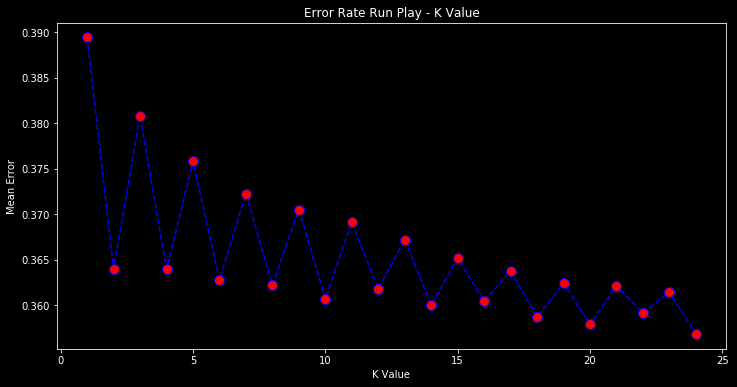

In [42]:
error = [] # Calculating error for K values between 1 and 25
for i in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_run_train, y_run_train)
    pred_i = knn.predict(X_run_test)
    error.append(np.mean(pred_i != y_run_test))
plt.figure(figsize=(12, 6)) 
plt.title('Error Rate Run Play - K Value')  
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.plot(range(1,25), error, color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)

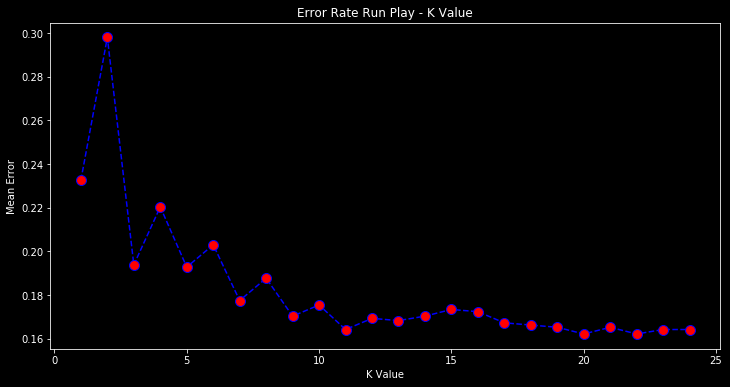

In [43]:
error = [] # Calculating error for K values between 1 and 25
for i in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_fg_train, y_fg_train)
    pred_i = knn.predict(X_fg_test)
    error.append(np.mean(pred_i != y_fg_test))
plt.figure(figsize=(12, 6)) 
plt.title('Error Rate Run Play - K Value')  
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.plot(range(1,25), error, color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)

## Modeling & Evaluation V
>Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

### Linear Regression
The advantages of the linear regression model is that it was able to produce a high accuracy and has a moderate run time. The models are able to compute around 1 minute, which is better than the other models. However, the downside of linear regression is the danger of false positives and false negatives. This is evident in the models for each task since it shows that accuracy is high but precision lags behind. For this very reason, linear regression was not our best performing model.

### KNN
The advantages of KNN is its blazing speed. It is able to take in the data and conduct the cross-validation within seconds compared to the minute of the linear regression model. However, the downside is its poor performance with respect to the metrics. The accuracy scores were in the 60s and the precision scores were in the 50s, which is substantially lower than the linear regression models. Since precision is critical for our performance, we are not able to select KNN for our tasks.

### Random Forest
Random Forest performed much better than the other models with respect to the metrics in question. It was averaging slightly higher than the linear regression model in the run task and substantially higher in the field goal task. This gives it the ability minimize fasle positives as much as possible, which is ideal in our given scenarios. The downside to Random Forest is the run time. The run time in the run task was around 6 minutes, which is considerably long for our purposes. However, we would consider refining the model and reducing the data set size to determine if performance could be optimized. This is not the case when using K-fold cross-validation, which sees performance come down to a matter of seconds. For its strength in precision, we decided Random Forest is by far the best model to use for both tasks.

In [ ]:
clf1 = Pipeline(

    [('PCA',PCA(n_components=100,svd_solver='randomized')),

     ('CLF',GaussianNB())]

)

clf2 = Pipeline(

    [('PCA',PCA(n_components=500,svd_solver='randomized')),

     ('CLF',GaussianNB())]

)





from sklearn.model_selection import cross_val_score

# is clf1 better or worse than clf2?

cv=StratifiedKFold(n_splits=10)
acc1 = cross_val_score(clf1, X, y=y, cv=cv)
acc2 = cross_val_score(clf2, X, y=y, cv=cv)

#=================================

t = 2.26 / np.sqrt(10)
e = (1-acc1)-(1-acc2)
# std1 = np.std(acc1)
# std2 = np.std(acc2)
stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot )
print (np.mean(acc1), np.mean(acc2))

#===============================

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized,cmap=plt.get_cmap('Reds'),aspect='auto')
plt.grid(False)

## Modeling & Evaluation VI
>Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

Looking further into the Random Forest models, we can see how the models assign importance to the features in the data. The most important model for both of them is `game_seconds_remaining` which is understandable. The amount of time remaining in a game will dictate whether a team should be running the ball (to chew clock) or kicking a field goal to tie/win the game. We also see the yardline feature is also the second more important in the data set. When running the ball, the yardline is certainly going to be a huge indicator in whether the ball will be ran or thrown. If the ball is inside the red zone, it is more likely to be a run than a pass. With respect to field goals, the yard line at which the ball is at is going to matter greatly. Clearly not as much as the time since you will see team attempting field goals they know are highly unlikely. However, the distance is certainly one critical component that determines whether a kick will be successful.
<br><br>
The third feature is different for both models. The run model values the down as the third highest feature. This is expected since the down and ydstogo (which is the next feature) determine whether a team is able to run the ball and convert a first down or if they should pass. For the field goal, it is kick_distance, which also makes sense. The kick_distance is something that allows coches to know whether the distance for the goal is within the range of their kicker. The closer to the range of their kicker, the more likely they are to attempt a field goal which will result in a successful kick. This would be the main reason why a field foal distance would be critical to the model.

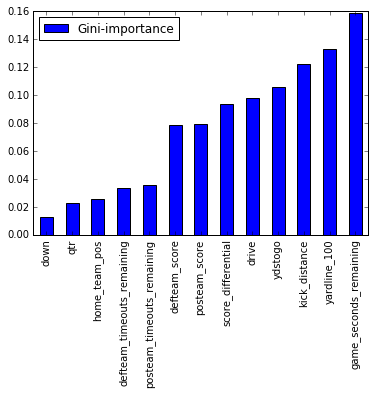

In [59]:
plt.style.use('classic')
%matplotlib inline
from sklearn.model_selection import train_test_split

df= nfl_fg_copy
X = df.drop('fieldgoal_made', axis=1)
y = df['fieldgoal_made']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
rf = RandomForestClassifier(n_estimators = 100,
                          n_jobs = -1,
                          oob_score = True,
                          bootstrap = True)

rf.fit(x_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_train.columns, rf.feature_importances_):
   feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)

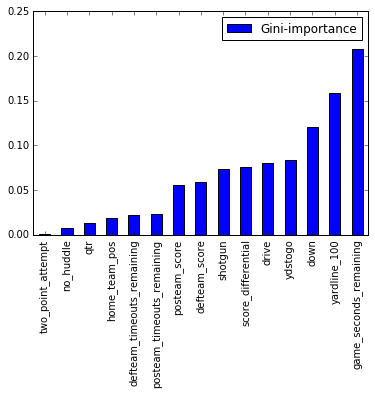

In [60]:
%matplotlib inline
from sklearn.model_selection import train_test_split

df= nfl_run_copy
X = df.drop('play_type_run', axis=1)
y = df['play_type_run']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
rf = RandomForestClassifier(n_estimators = 100,
                          n_jobs = -1,
                          oob_score = True,
                          bootstrap = True)

rf.fit(x_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_train.columns, rf.feature_importances_):
   feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)

## Deployment
>How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

The current decision making in the NFL lies with the offensive and defensive coordinators (unless the head coach has reserved play-calling rights). During the game, these individuals are forced to rely on past experiences, knowledge, and intuition to make game-time decisions in a matter of seconds. These decisions could have a monumental impact on the tide of the game, which is part of the reason less than 50% of head coaches last less than 3 years with a team and why less than 30% of head coaches last less than 5 years with a team [3](https://www.footballperspective.com/head-coach-retention-rates/). When a team is performing poorly, the head coach is normally the first one to get fired.
<br><br>
These models will help the coaching staff make data-driven decisions supported by analytics. The model pertaining to the run play will give defensive coaches the ability to determine whether the offense is considering a run play. From a defensive perspective, knowing whether the play is a run or a pass is critical because the team is able to position itself in a position to be able to better defend against the run. Furthermore, a model that is able to determine the probability of a successful field goal is also significant since it will give the coach the ability to remove some of the risk associated with attempting a field goal. This model may also be further optimized if it were applied to specific players under given conditions.
<br><br>
Whether it is making the right defensive play or deciding if a field goal should be attempted, these models have the capability to help new and tenured coaches make informed decisions. It removes some of the 'luck' aspect of the game and helps drive greater competition. Defense wins Championships. Special Teams win Super Bowls!

## Exceptional Work
>You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?

During the process of optimiztion, one of the discoveries we made was that the amount of input required to train the KNN algorithm could be drastically reduced and performance would not suffer. This has serious implication since it gives the ability to use more recent and relevant data with respect to teams and players while providing strong results.

In [45]:
%%time
#create the split
cv_object1 = StratifiedShuffleSplit( n_splits=10,test_size=0.9)

# KNN model
knn = KNeighborsClassifier(n_neighbors=10)

# create empty variables for loop
iter_num=0
t_acc=0
t_prec=0

# loop for KNN model
print(knn)
for train_indices_run, test_indices_run in cv_object1.split(X_run,y_run): 

    X_run_train = X_run[train_indices_run]
    y_run_train = y_run[train_indices_run]
    
    X_run_test = X_run[test_indices_run]
    y_run_test = y_run[test_indices_run]

    knn.fit(X_run_train, y_run_train)  # train model
    y_hat_run = knn.predict(X_run_test) # test model

    acc = mt.accuracy_score(y_run_test,y_hat_run) # accuracy of model for given instance
    prec = mt.precision_score(y_run_test,y_hat_run) # precision score of model
#     print('\n#',iter_num+1,"Cross-Validation\n Accuracy:",
#           str(round(acc*100, 2)),"%\n Precision:",str(round(prec*100, 2)),'%\n Confusion Matrix \n',
#           confusion_matrix(y_run_test, y_hat_run))
    
    t_prec = t_prec+prec
    t_acc = t_acc+acc # running total of accuracies
    iter_num+=1 # iteration counter
    
print('\nAvg. Accuracy:',str(round(t_acc/10*100, 2)),'%') # print average accuracy of model
print('Avg. Precision:', str(round(t_prec/10*100, 2)),'%')
print(classification_report(y_run_test, y_hat_run))# print performance metrics of model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

Avg. Accuracy: 62.43 %
Avg. Precision: 48.71 %
              precision    recall  f1-score   support

           0       0.65      0.85      0.74    202399
           1       0.49      0.24      0.32    119423

   micro avg       0.62      0.62      0.62    321822
   macro avg       0.57      0.55      0.53    321822
weighted avg       0.59      0.62      0.58    321822

Wall time: 43.3 s


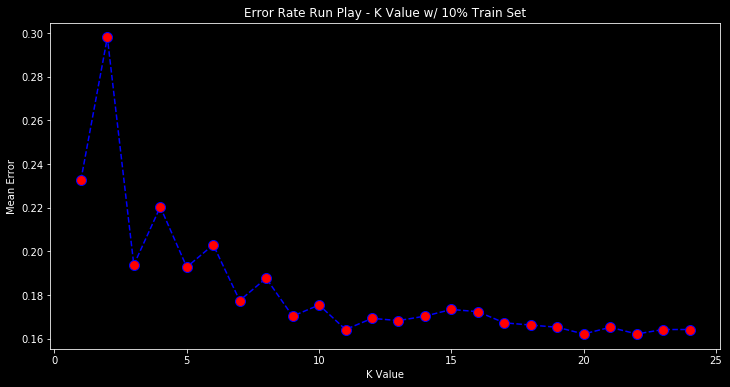

In [46]:
error = [] # Calculating error for K values between 1 and 25
for i in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_fg_train, y_fg_train)
    pred_i = knn.predict(X_fg_test)
    error.append(np.mean(pred_i != y_fg_test))
plt.figure(figsize=(12, 6)) 
plt.title('Error Rate Run Play - K Value w/ 10% Train Set')  
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.plot(range(1,25), error, color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)

In [58]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']
